In [22]:
# LOAD LIBRERIES

import numpy as np
import threading
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
from copy import deepcopy
from collections import Counter
from sklearn import svm, manifold, preprocessing
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.svm import SVC
import random

random.seed(123)

In [23]:
# DOWNOAD ZIP FILES

!wget --no-verbose https://www.dsi.unive.it/~atorsell/AI/graph/PPI.zip
!wget --no-verbose https://www.dsi.unive.it/~atorsell/AI/graph/SHOCK.zip

2022-07-06 13:33:29 URL:https://www.dsi.unive.it/~atorsell/AI/graph/PPI.zip [96834/96834] -> "PPI.zip" [1]
2022-07-06 13:33:29 URL:https://www.dsi.unive.it/~atorsell/AI/graph/SHOCK.zip [36697/36697] -> "SHOCK.zip" [1]


In [24]:
# EXTRACT AND DELETE THEM

!unzip -qq -o '/content/PPI.zip' 
!unzip -qq -o '/content/SHOCK.zip' 
!rm '/content/PPI.zip'
!rm '/content/SHOCK.zip'

In [25]:
# LOAD GRAPHS AND LABELS

DS = ['PPI', 'SHOCK']
PATH = ['/content/GoogleDrive/Corsi/AI/graph/datasets/' + ds + '/' for ds in DS]
LIST = [sorted(os.listdir(path)) for path in PATH]
for l in LIST: l.remove('labels.csv')
GRAPHS = [[pd.read_csv(PATH[idx] + f, header=None).to_numpy() for f in lis] for idx, lis in enumerate(LIST)]
LABELS = [pd.read_csv(path + 'labels.csv', header=None).to_numpy().ravel() for path in PATH]

In [26]:
class WeisfeilerLehman:

  # Dot product between the adjecent matrix and a column vector of 1 result -> vector of node degree
  def get_graph_starting_labels(self, graph):
    return np.ravel(np.dot(graph, np.ones((len(graph), 1)))).tolist()
  
  # Create a list containing for index the id of graph and for value the column vector of starting labels
  def get_all_starting_labels(self):
    return [self.get_graph_starting_labels(self.graphs[graphID]) for graphID in range(self.n_graphs)]

  # Given the index of the graph and node we retunr the list of indeces of neighbors 
  def get_neighbors(self, graph, node): 
    return [j for j in range(len(graph)) if graph[node][j] == 1]

  # Get the label of each node's graphs
  def get_node_labels(self, graphID, node):
    sorted_label_neigh = sorted([self.labels[graphID][int(i)] for i in self.get_neighbors(self.graphs[graphID], node)])
    suffix = ''.join(str(int(lab)) for lab in sorted_label_neigh)
    return (str(self.labels[graphID][node]) + suffix)

  # For each node in the graph g we run get labels and add the restult to a vector with index the id the respective graph node
  def compute_and_extend_new_labels(self, graphID): 
    return [self.get_node_labels(graphID, node) for node in range(len(self.graphs[graphID]))]

  # Relabeling function
  def reLabel(self, graphID, new_labels):
    for nodeID in range(len(new_labels)):
      if new_labels[nodeID] not in self.compressed_labels:
        self.compressed_index += 1
        self.compressed_labels[new_labels[nodeID]] = str(self.compressed_index)
      self.labels[graphID][nodeID] = self.compressed_labels[new_labels[nodeID]]

  # Generic function to count the node labels
  def count_node_labels(self, l):
    l = list(map(int, l)) # self.original_labels[g] -> list of string, trasform in list of int
    c = Counter(l) # generate the counter
    phi = np.zeros(max(l)+1) # create a vector of zer of dim max(l) +1 because we have to take into account also node with no edge connection, max of c retunr the maximum key so the maximum value in the original array
    for k in range(max(l)+1):
      if k in c: phi[k] = c[k]
    return phi

  # Function to prepare feature vectors for the dot product
  def generate_feature_vectors(self, graphID1, graphID2):
    cl_1 = self.count_labels[graphID1] # contains the label used for each iteration
    cl_2 = self.count_labels[graphID2]
    v1, v2 = [], []
    mi = 0

    for i in range(self.h):
      if len(cl_1[i]) > len(cl_2[i]):
        a = len(cl_1[i]) - len(cl_2[i])
        cl_2[i] = np.append(cl_2[i],[0 for _ in range(a)])
      elif len(cl_2[i]) > len(cl_1[i]):
        a = len(cl_2[i]) - len(cl_1[i])
        cl_1[i] = np.append(cl_1[i],[0 for _ in range(a)])
      v1 = np.concatenate((v1, cl_1[i][mi:]), axis=0)
      v2 = np.concatenate((v2, cl_2[i][mi:]), axis=0)
      mi = len(cl_1[i])
    return v1, v2

  # Pairwise similarities between all the graphs
  def pairwise_similarities(self):
    for row in range(self.n_graphs):
      for col in range(row, self.n_graphs):
        v1, v2 = self.generate_feature_vectors(row, col)
        res = np.dot(v1, v2)
        self.pairwise_sim_matrix[row][col] = res
        self.pairwise_sim_matrix[col][row] = res
    self.pairwise_sim_matrix = preprocessing.normalize(self.pairwise_sim_matrix)
    return self.pairwise_sim_matrix

  # Fucntion that run the whole algorithm with all four steps
  def run(self):
    for iter in range(1, self.h):
      for graphID in range(self.n_graphs):
        new_labels = self.compute_and_extend_new_labels(graphID) #list of list of char
        self.reLabel(graphID, new_labels)
        self.count_labels[graphID][iter] = self.count_node_labels(self.labels[graphID])
    return self.pairwise_similarities()

  # Initialization of the class
  def __init__(self, graphs, iter):
    self.n_graphs = len(graphs)
    self.graphs = graphs
    self.h = iter + 1
    self.labels = [list(map(int, l)) for l in self.get_all_starting_labels()]
    self.original_labels = deepcopy(self.labels)
    self.compressed_index = max([max(map(int, vecDegree)) for vecDegree in self.labels])
    
    self.compressed_labels = {} # ditionary: newlabel_uncompressed -> label compressed (mapped)
    self.count_labels = np.empty((self.n_graphs, self.h), dtype=object)
    for graphID in range(self.n_graphs):
      self.count_labels[graphID][0] = self.count_node_labels(self.original_labels[graphID])
    # key: 0 -> value: counts of original node labels fot the 0 iteration

    self.pairwise_sim_matrix = np.zeros((self.n_graphs, self.n_graphs))


In [27]:
WL = [WeisfeilerLehman(graph, 5) for graph in GRAPHS]
threads = [threading.Thread(name=DS[idx], target=wl.run) for idx, wl in enumerate(WL)]

for t in threads: t.start()
for t in threads: t.join()

pd_mats = [pairwise_distances(wl.pairwise_sim_matrix, metric='euclidean') for wl in WL]

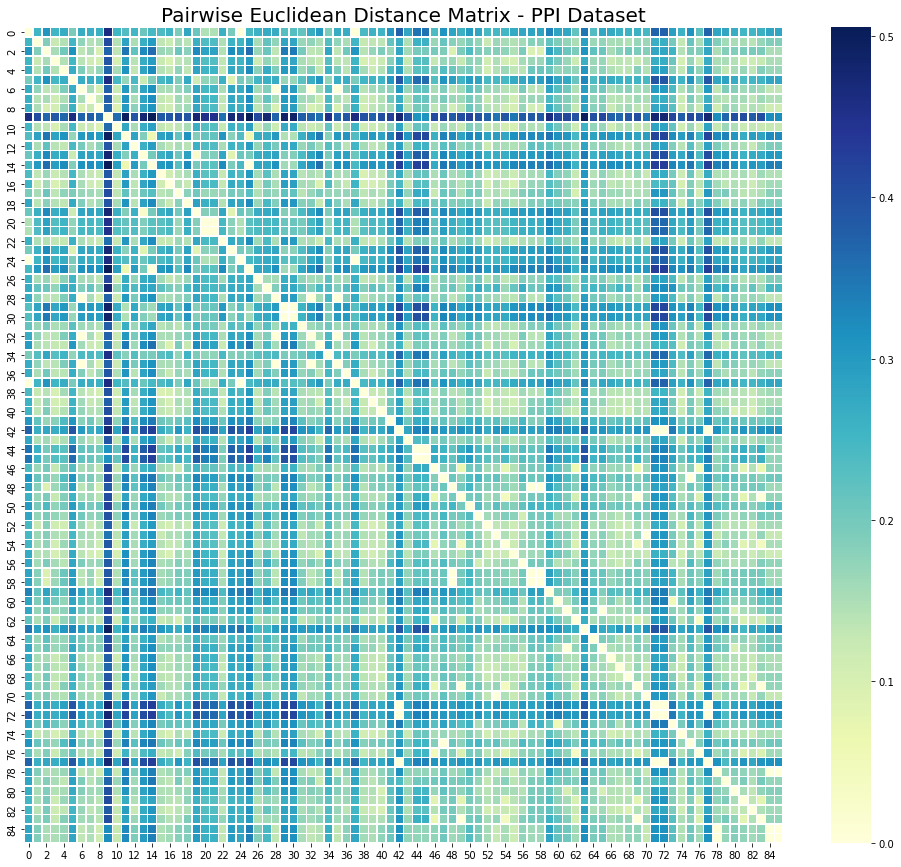

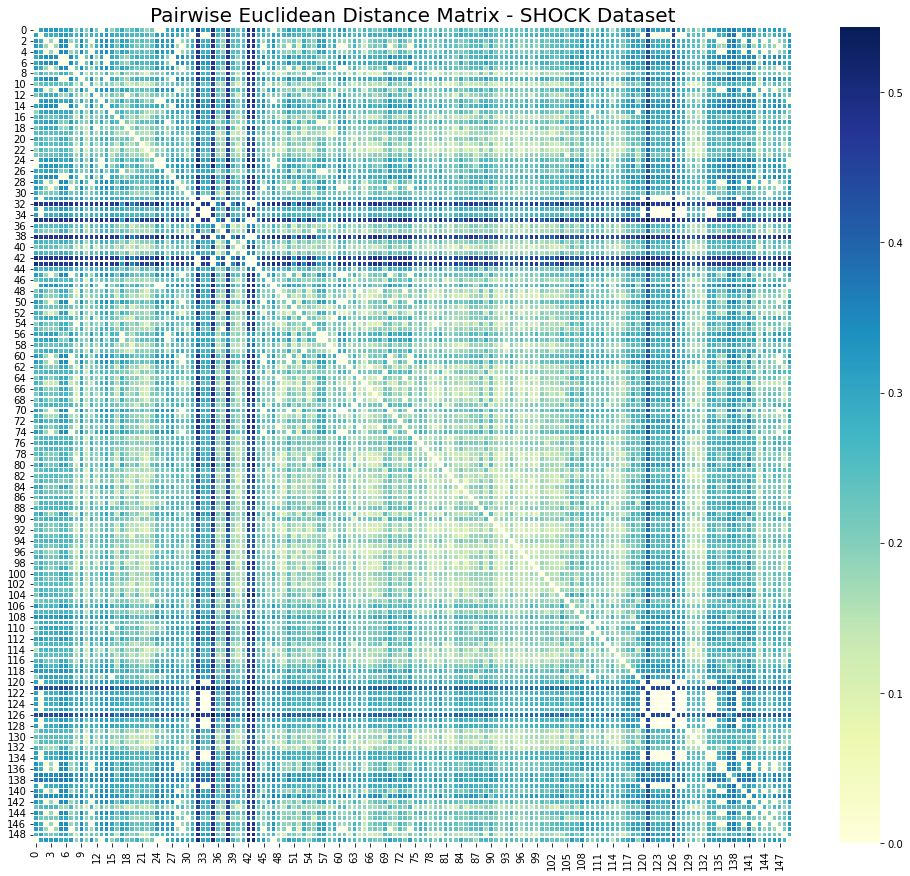

In [28]:
for idx, pd in enumerate(pd_mats):
  fig = plt.figure(figsize=(17,15))
  p = sns.heatmap(pd, cmap="YlGnBu", linewidth=.5,)
  p.set_title("Pairwise Euclidean Distance Matrix - " + DS[idx] + " Dataset", {'fontsize': 20})
  plt.show()
  print('\n')

In [29]:
import pandas as pd

cols_wl = ['Dataset', 'Minimum', 'Mean', 'Maximum', 'Variance', 'Standard Deviation']
cols_ml = ['Dataset', 'Minimum', 'Mean', 'Maximum', 'Variance', 'Standard Deviation', '# Neighbors', '# Components']
temp_wl = []
temp_ml = [[], []]

In [30]:
kfold = StratifiedKFold(n_splits = 10, shuffle = True) 
clf = svm.SVC(kernel="linear")
for idx in range(len(DS)):
  cv_score = cross_val_score(clf, pd_mats[idx], LABELS[idx], cv = kfold)
  temp_wl.append([DS[idx], round(np.min(cv_score), 3), round(np.mean(cv_score), 3), round(np.max(cv_score), 3), round(np.var(cv_score), 3), round(np.std(cv_score), 3)])
wl_df = pd.DataFrame(temp_wl, columns = cols_wl)
wl_df

,Dataset,Minimum,Mean,Maximum,Variance,Standard Deviation
0,PPI,0.5,0.706,0.889,0.013,0.116
1,SHOCK,0.2,0.333,0.467,0.010,0.099


In [31]:
for n_neigh in range(2, 30):
  for n_comp in range(2, 20):
    for idx in range(len(DS)):
      mod_iso = manifold.Isomap(n_neighbors = n_neigh, n_components = n_comp, n_jobs = -1).fit_transform(pd_mats[idx])
      cv_score_iso = cross_val_score(clf, mod_iso, LABELS[idx], cv = kfold, n_jobs = -1)
      temp_ml[0].append([
                         DS[idx], round(np.min(cv_score_iso), 3),
                         round(np.mean(cv_score_iso), 3), round(np.max(cv_score_iso), 3),
                         round(np.var(cv_score_iso), 3), round(np.std(cv_score_iso), 3),
                         n_neigh, n_comp])

      mod_lle = manifold.LocallyLinearEmbedding(n_neighbors = n_neigh, n_components = n_comp, n_jobs = -1).fit_transform(pd_mats[idx])
      cv_score_lle = cross_val_score(clf, mod_lle, LABELS[idx], cv = kfold, n_jobs = -1)
      temp_ml[1].append([
                         DS[idx], round(np.min(cv_score_lle), 3),
                         round(np.mean(cv_score_lle), 3), round(np.max(cv_score_lle), 3),
                         round(np.var(cv_score_lle), 3), round(np.std(cv_score_lle), 3),
                         n_neigh, n_comp])

Output streaming troncato alle ultime 5000 righe.
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_i

In [32]:
ml_iso_df = pd.DataFrame(temp_ml[0], columns = cols_ml)
ml_lle_df = pd.DataFrame(temp_ml[1], columns = cols_ml)

ml_iso_df_ppi = ml_iso_df[ml_iso_df['Dataset'] == 'PPI']
ml_iso_df_shock = ml_iso_df[ml_iso_df['Dataset'] == 'SHOCK']

ml_lle_df_ppi = ml_lle_df[ml_lle_df['Dataset'] == 'PPI']
ml_lle_df_shock = ml_lle_df[ml_lle_df['Dataset'] == 'SHOCK']

In [33]:
print("BEST AND WORST RESULTS USING ISOMAP")
print("Best run for PPI Dataset")
display(ml_iso_df_ppi.loc[ml_iso_df_ppi['Mean'].idxmax()])
print("\nBest run for SHOCK Dataset")
display(ml_iso_df_shock.loc[ml_iso_df_shock['Mean'].idxmax()])
print("\nWorst run for PPI Dataset")
display(ml_iso_df_ppi.loc[ml_iso_df_ppi['Mean'].idxmin()])
print("\nWorst run for SHOCK Dataset")
display(ml_iso_df_shock.loc[ml_iso_df_shock['Mean'].idxmin()])

BEST AND WORST RESULTS USING ISOMAP
Best run for PPI Dataset


Dataset                 PPI
Minimum               0.556
Mean                   0.84
Maximum                 1.0
Variance              0.015
Standard Deviation    0.122
# Neighbors               5
# Components              5
Name: 114, dtype: object


Best run for SHOCK Dataset


Dataset               SHOCK
Minimum                 0.2
Mean                  0.427
Maximum               0.667
Variance              0.014
Standard Deviation     0.12
# Neighbors              10
# Components             17
Name: 319, dtype: object


Worst run for PPI Dataset


Dataset                 PPI
Minimum               0.375
Mean                  0.626
Maximum               0.778
Variance              0.014
Standard Deviation    0.119
# Neighbors               6
# Components              4
Name: 148, dtype: object


Worst run for SHOCK Dataset


Dataset               SHOCK
Minimum                 0.0
Mean                  0.187
Maximum               0.333
Variance               0.01
Standard Deviation    0.102
# Neighbors              22
# Components              5
Name: 727, dtype: object

In [34]:
print("BEST AND WORST RESULTS USING LLE")
print("Best run for PPI Dataset")
display(ml_lle_df_ppi.loc[ml_lle_df_ppi['Mean'].idxmax()])
print("\nBest run for SHOCK Dataset")
display(ml_lle_df_shock.loc[ml_lle_df_shock['Mean'].idxmax()])
print("\nWorst run for PPI Dataset")
display(ml_lle_df_ppi.loc[ml_lle_df_ppi['Mean'].idxmin()])
print("\nWorst run for SHOCK Dataset")
display(ml_lle_df_shock.loc[ml_lle_df_shock['Mean'].idxmin()])

BEST AND WORST RESULTS USING LLE
Best run for PPI Dataset


Dataset                 PPI
Minimum               0.556
Mean                   0.85
Maximum                 1.0
Variance              0.013
Standard Deviation    0.113
# Neighbors              10
# Components             19
Name: 322, dtype: object


Best run for SHOCK Dataset


Dataset               SHOCK
Minimum               0.133
Mean                  0.227
Maximum               0.333
Variance              0.006
Standard Deviation    0.074
# Neighbors              25
# Components             19
Name: 863, dtype: object


Worst run for PPI Dataset


Dataset                 PPI
Minimum                 0.5
Mean                  0.533
Maximum               0.556
Variance              0.001
Standard Deviation    0.027
# Neighbors               2
# Components              2
Name: 0, dtype: object


Worst run for SHOCK Dataset


Dataset               SHOCK
Minimum                 0.0
Mean                  0.053
Maximum                 0.2
Variance              0.004
Standard Deviation    0.065
# Neighbors               2
# Components              2
Name: 1, dtype: object

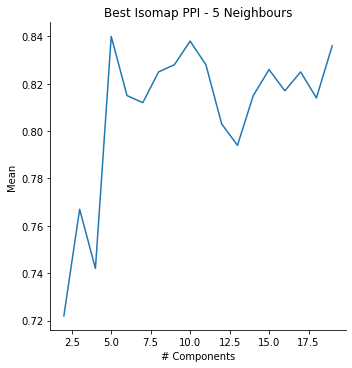

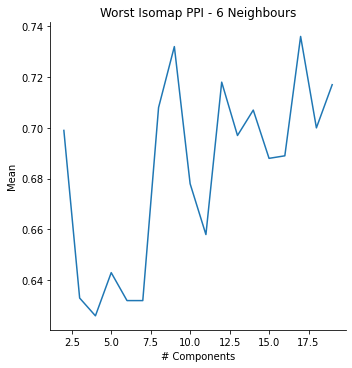

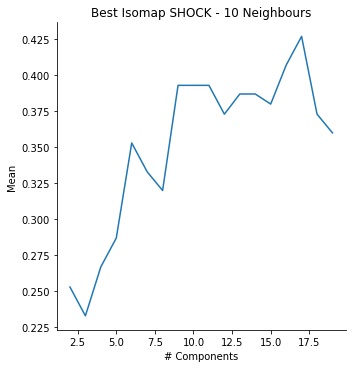

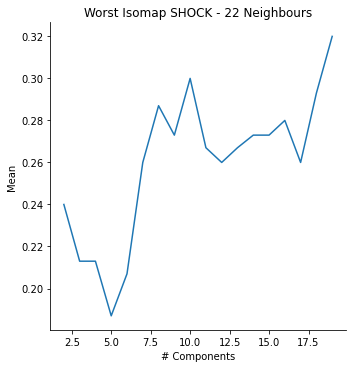

In [35]:
neigh_best_iso_df_ppi = ml_iso_df_ppi.loc[ml_iso_df_ppi['Mean'].idxmax()][6]
df_plot = ml_iso_df_ppi.loc[ml_iso_df_ppi['# Neighbors'] == neigh_best_iso_df_ppi]
sns.relplot(x="# Components", y="Mean", ci=None, kind="line", data = df_plot).set(title="Best Isomap PPI - " + str(neigh_best_iso_df_ppi) + " Neighbours")

neigh_worst_iso_df_ppi = ml_iso_df_ppi.loc[ml_iso_df_ppi['Mean'].idxmin()][6]
df_plot = ml_iso_df_ppi.loc[ml_iso_df_ppi['# Neighbors'] == neigh_worst_iso_df_ppi]
sns.relplot(x="# Components", y="Mean", ci=None, kind="line", data = df_plot).set(title="Worst Isomap PPI - " + str(neigh_worst_iso_df_ppi) + " Neighbours")

neigh_best_iso_df_shock = ml_iso_df_shock.loc[ml_iso_df_shock['Mean'].idxmax()][6]
df_plot = ml_iso_df_shock.loc[ml_iso_df_shock['# Neighbors'] == neigh_best_iso_df_shock]
sns.relplot(x="# Components", y="Mean", ci=None, kind="line", data = df_plot).set(title="Best Isomap SHOCK - " + str(neigh_best_iso_df_shock) + " Neighbours")

neigh_worst_iso_df_shock = ml_iso_df_shock.loc[ml_iso_df_shock['Mean'].idxmin()][6]
df_plot = ml_iso_df_shock.loc[ml_iso_df_shock['# Neighbors'] == neigh_worst_iso_df_shock]
sns.relplot(x="# Components", y="Mean", ci=None, kind="line", data = df_plot).set(title="Worst Isomap SHOCK - " + str(neigh_worst_iso_df_shock) + " Neighbours")

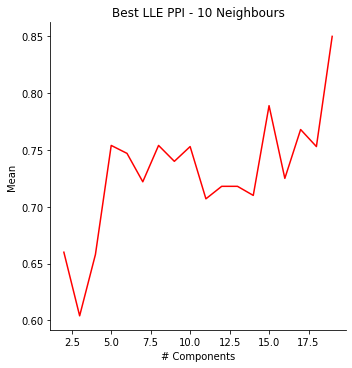

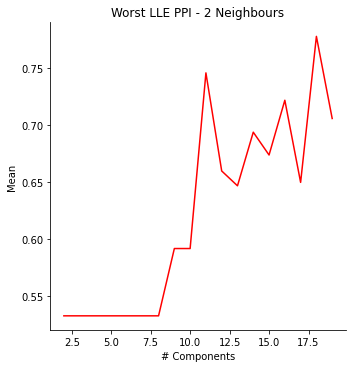

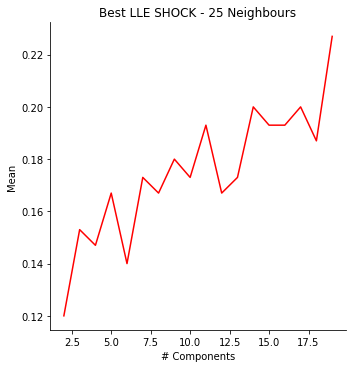

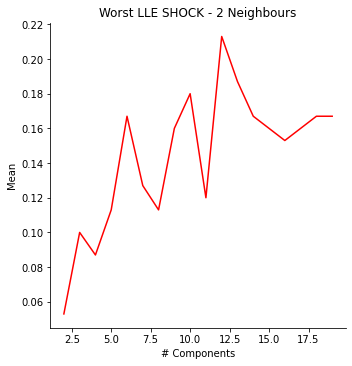

In [36]:
neigh_best_lle_df_ppi = ml_lle_df_ppi.loc[ml_lle_df_ppi['Mean'].idxmax()][6]
df_plot = ml_lle_df_ppi.loc[ml_lle_df_ppi['# Neighbors'] == neigh_best_lle_df_ppi]
sns.relplot(x="# Components", y="Mean", ci=None, kind="line", data = df_plot, color="r").set(title="Best LLE PPI - " + str(neigh_best_lle_df_ppi) + " Neighbours")

neigh_worst_lle_df_ppi = ml_lle_df_ppi.loc[ml_lle_df_ppi['Mean'].idxmin()][6]
df_plot = ml_lle_df_ppi.loc[ml_lle_df_ppi['# Neighbors'] == neigh_worst_lle_df_ppi]
sns.relplot(x="# Components", y="Mean", ci=None, kind="line", data = df_plot, color="r").set(title="Worst LLE PPI - " + str(neigh_worst_lle_df_ppi) + " Neighbours")

neigh_best_lle_df_shock = ml_lle_df_shock.loc[ml_lle_df_shock['Mean'].idxmax()][6]
df_plot = ml_lle_df_shock.loc[ml_lle_df_shock['# Neighbors'] == neigh_best_lle_df_shock]
sns.relplot(x="# Components", y="Mean", ci=None, kind="line", data = df_plot, color="r").set(title="Best LLE SHOCK - " + str(neigh_best_lle_df_shock) + " Neighbours")

neigh_worst_lle_df_shock = ml_lle_df_shock.loc[ml_lle_df_shock['Mean'].idxmin()][6]
df_plot = ml_lle_df_shock.loc[ml_lle_df_shock['# Neighbors'] == neigh_worst_lle_df_shock]
sns.relplot(x="# Components", y="Mean", ci=None, kind="line", data = df_plot, color="r").set(title="Worst LLE SHOCK - " + str(neigh_worst_lle_df_shock) + " Neighbours")